In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

NUM_SAMPLES = 1000
NUM_CLASSES = 6
NUM_FEATURES = 2
RANDOM_SEED = 42


In [2]:
# CREATE MULTI-CLASS DATA
X_blob, y_blob = make_blobs(n_samples=NUM_SAMPLES,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5,
                            random_state=RANDOM_SEED
                            )

# TURN DATA INTO TENSORS
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

print(f"Shape of X_blob: {X_blob.shape}")
print(f"Shape of y_blob: {y_blob.shape}")

Shape of X_blob: torch.Size([1000, 2])
Shape of y_blob: torch.Size([1000])


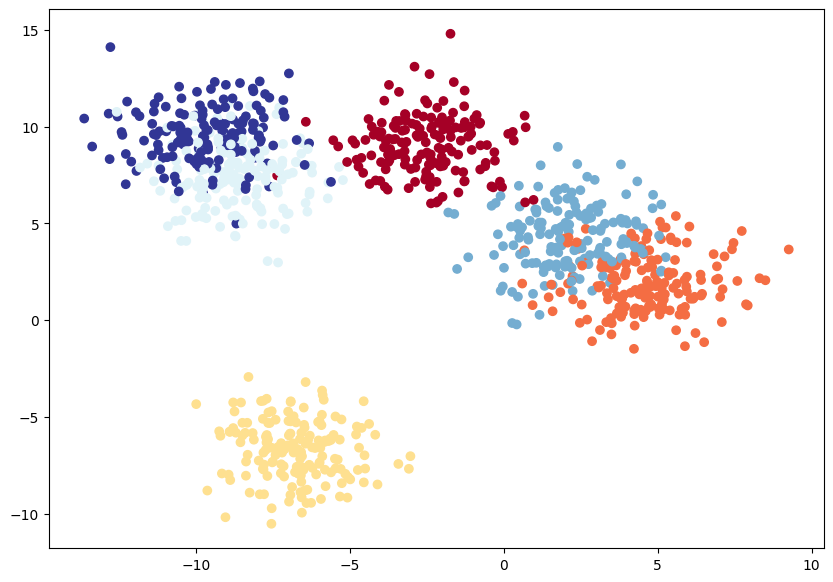

In [3]:
# SPLIT INTO TRAIN AND TEST
X_train, X_test, y_train, y_test = train_test_split(X_blob,
                                                    y_blob,
                                                    test_size=0.2,
                                                    random_state=RANDOM_SEED
                                                    )

# PLOT DATA
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

In [4]:
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features),
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

# CREATE INSTANCE OF BLOB AND SEND TO TARGET DEVICE
model = BlobModel(input_features=2,
                  output_features=NUM_CLASSES,
                  hidden_units=8)
print(f"Model: {model}")

Model: BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=6, bias=True)
  )
)


In [5]:
# CREATE LOSS FUNCTION AND OPTIMIZER
loss_function = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params=model.parameters(),
                            lr=0.1)

In [6]:
from helper_functions import plot_decision_boundary

def plot_boundaries(
    model: nn.Module,
    train_data: torch.Tensor = X_train,
    train_labels: torch.Tensor = y_train,
    test_data: torch.Tensor = X_test,
    test_labels: torch.Tensor = y_test,
    ):
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.title("Train")
    plot_decision_boundary(model, train_data, train_labels)
    plt.subplot(1, 2, 2)
    plt.title("Test")
    plot_decision_boundary(model, test_data, test_labels)

def train(
        model: nn.Module,
        loss_function: nn.Module = loss_function,
        optimizer: optim.Optimizer = optimizer,
        train_data: torch.Tensor = X_train,
        train_labels: torch.Tensor = y_train,
        test_data: torch.Tensor = X_test,
        test_labels: torch.Tensor = y_test,
        num_epochs: int = 100,
    ):
    epochs_count, train_loss_arr, test_loss_arr = [], [], []
    for epoch in range(num_epochs):
        model.train()

        y_preds = model(train_data)

        loss = loss_function(y_preds, train_labels)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        model.eval()
        with torch.inference_mode():
            y_preds = model(test_data)
            test_loss = loss_function(y_preds, test_labels)

            if epoch % 10 == 0:
                epochs_count.append(epoch)
                train_loss_arr.append(loss.detach().numpy())
                test_loss_arr.append(test_loss.detach().numpy())
                print(f"Epoch {epoch}: train loss {loss}, test loss {test_loss}")
    return epochs_count, train_loss_arr, test_loss_arr


def predict(model: nn.Module, data: torch.Tensor) -> torch.Tensor:
    model.eval()
    with torch.inference_mode():
        return model(data)
    
def plot_stats(
        epochs: list,
        train_loss: list,
        test_loss: list,
    ):
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_loss, label='Train loss')
    plt.plot(epochs, test_loss, label='Test loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

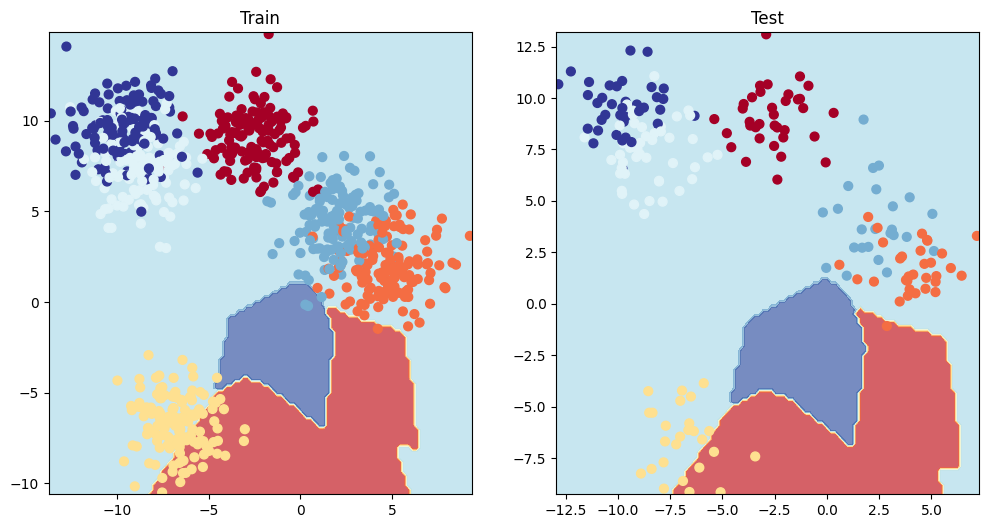

In [7]:
plot_boundaries(model)

In [8]:
epochs_count, train_loss, test_loss = train(model)

Epoch 0: train loss 2.167447328567505, test loss 1.5749304294586182
Epoch 10: train loss 0.4191212058067322, test loss 0.43108096718788147
Epoch 20: train loss 0.35131198167800903, test loss 0.4544156789779663
Epoch 30: train loss 0.33100906014442444, test loss 0.41054224967956543
Epoch 40: train loss 0.307217001914978, test loss 0.3771241307258606
Epoch 50: train loss 0.28940892219543457, test loss 0.33197128772735596
Epoch 60: train loss 0.2726384103298187, test loss 0.3030090034008026
Epoch 70: train loss 0.2663355767726898, test loss 0.29474541544914246
Epoch 80: train loss 0.2641492187976837, test loss 0.2931535840034485
Epoch 90: train loss 0.2643282413482666, test loss 0.30310264229774475


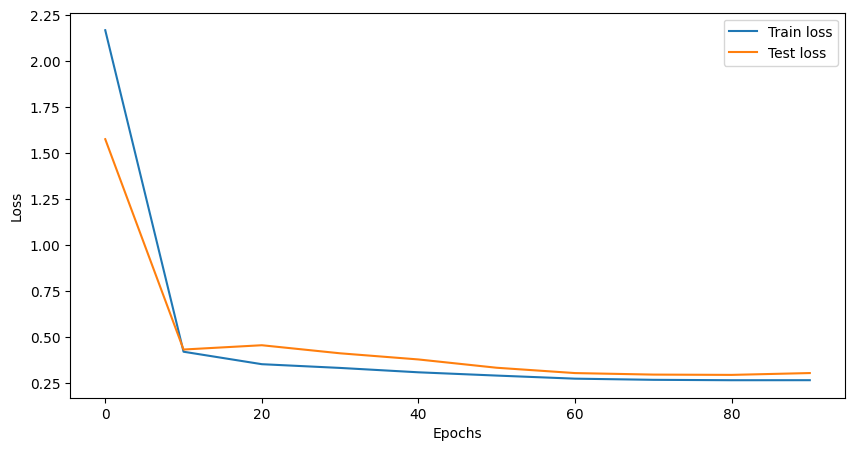

In [9]:
plot_stats(epochs=epochs_count, train_loss=train_loss, test_loss=test_loss)


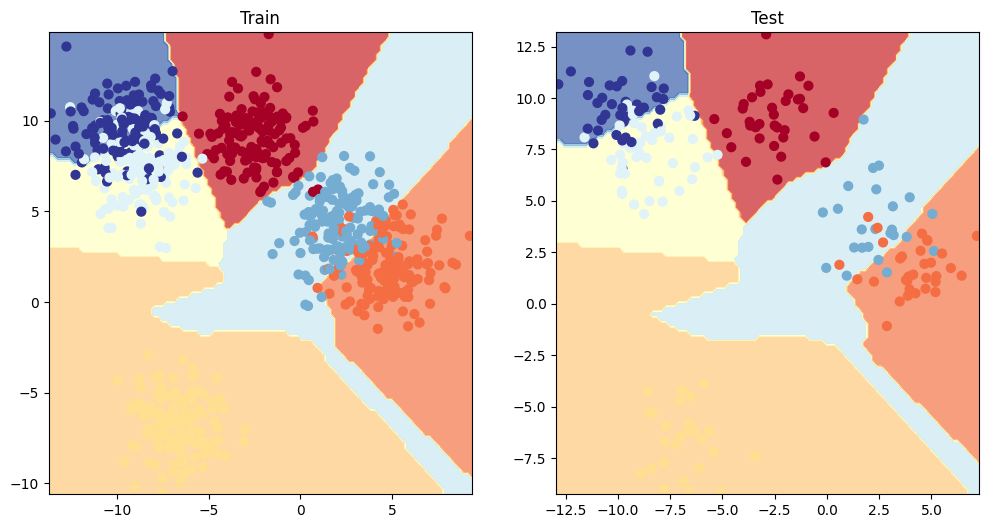

In [10]:
plot_boundaries(model)

In [11]:
with torch.inference_mode():
    y_logits = model(X_test)

print(f"Logits: {y_logits[:10]}")

Logits: tensor([[ -9.8814,  15.3766, -15.1520, -26.1791,  13.8293, -37.2853],
        [ -9.8485,  15.4872, -15.5858, -26.6599,  13.9915, -37.6907],
        [-39.7546,  -9.7387,  18.6413,  -4.8444,   0.6358, -53.9638],
        [  1.1773, -21.6945,   0.7861,  11.7848, -10.3991,   8.2132],
        [ 12.1714,  -6.8949, -26.0417,  -3.4225,   2.3702,  -4.2380],
        [  2.9549,   4.2260, -25.2142, -20.5162,   9.2875, -22.8260],
        [  8.9003, -32.9782,  -6.1196,  19.1759, -16.5567,  20.7134],
        [-21.7396,  27.3858, -13.1863, -35.7049,  19.9602, -56.4042],
        [-30.7397,  -7.0714,  13.9706,  -3.8820,   0.9953, -42.6923],
        [-18.0421,  23.2076, -12.5077, -31.2053,  17.5082, -49.0603]])


In [12]:
y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1)

print(f"Predictions: {y_preds}")
print(f"Actual: {y_test}")

Predictions: tensor([1, 1, 2, 3, 0, 4, 5, 1, 2, 1, 0, 3, 1, 3, 2, 4, 5, 0, 1, 2, 1, 5, 4, 1,
        0, 4, 5, 1, 2, 3, 3, 3, 1, 4, 3, 1, 4, 3, 1, 0, 4, 0, 5, 1, 3, 0, 5, 2,
        3, 2, 1, 3, 3, 4, 2, 1, 5, 3, 3, 0, 5, 0, 1, 1, 2, 5, 2, 1, 5, 5, 2, 4,
        3, 0, 4, 0, 3, 0, 3, 0, 2, 5, 5, 3, 2, 0, 2, 0, 0, 2, 2, 2, 0, 3, 4, 1,
        5, 0, 5, 2, 5, 4, 0, 4, 0, 0, 0, 4, 0, 3, 2, 3, 1, 4, 0, 3, 5, 5, 1, 4,
        3, 1, 5, 2, 0, 5, 5, 3, 4, 5, 3, 3, 4, 1, 3, 0, 5, 3, 4, 1, 1, 3, 2, 3,
        3, 1, 5, 3, 1, 1, 3, 3, 0, 5, 2, 4, 3, 3, 1, 0, 0, 4, 3, 3, 5, 0, 0, 2,
        3, 5, 4, 5, 0, 0, 3, 5, 5, 0, 5, 5, 1, 4, 2, 3, 3, 3, 0, 3, 1, 3, 3, 3,
        2, 1, 3, 1, 0, 5, 5, 2])
Actual: tensor([1, 1, 2, 3, 0, 4, 5, 1, 2, 1, 0, 3, 1, 3, 2, 4, 5, 0, 4, 2, 1, 5, 4, 1,
        0, 4, 5, 1, 2, 3, 3, 3, 4, 4, 3, 1, 1, 5, 1, 0, 4, 0, 5, 1, 5, 0, 5, 2,
        3, 2, 1, 3, 5, 4, 2, 1, 5, 5, 3, 0, 5, 0, 4, 1, 2, 5, 2, 1, 3, 5, 2, 4,
        3, 3, 4, 0, 3, 0, 3, 0, 2, 3, 5, 3, 2, 0, 2, 0, 0, 2, 2, 2

In [13]:
from torchmetrics import Accuracy

# Setup metric and make sure it's on the target device
accuracy = Accuracy(task='multiclass', num_classes=6)

# Calculate accuracy
accuracy(y_preds, y_test)

tensor(0.8700)